# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
from sklearn.metrics import accuracy_score
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords','averaged_perceptron_tagger'])

%matplotlib inline

df = pd.read_csv('Data/user-item-interactions.csv')
df_content = pd.read_csv('Data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# check top rows for df
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# check top rows for df_content
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [3]:
# Fill in the median and maximum number of user_article interactios below
median_val = df.groupby(['email'])['article_id'].count().median()# 50% of individuals interact with ____ number of articles or fewer.
print(median_val)
max_views_by_user = df.groupby(['email'])['article_id'].count().max()# The maximum number of user-article interactions by any 1 user is ______.
print(max_views_by_user)

3.0
364


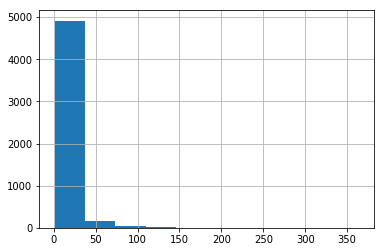

In [4]:
# How many articles a user interacts with in the dataset
df.groupby(['email'])['article_id'].count().sort_values().hist()

In [5]:
# check how many duplicates exists based on the article_id coplumn
df_content['article_id'].duplicated().sum()

5

In [6]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = ['article_id']
                          ,keep = 'first'
                          ,inplace = True)
df_content['article_id'].duplicated().sum()

0

In [7]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [8]:
# The number of unique articles that have at least one interaction
print(df['article_id'].nunique())
# The number of unique articles on the IBM platform
print(df_content['article_id'].nunique())
# The number of unique users
print(df['email'].nunique())
# The number of user-article interactions
print(df.shape[0])

714
1051
5148
45993


In [9]:
unique_articles = df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users = df['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

In [10]:
# The most viewed article id in the dataset
print(str(df.groupby(['article_id'])['title'].count().sort_values(ascending = False).index[0]))
# The most viewed article in the dataset was viewed how many times?
print(df.groupby(['article_id'])['title'].count().max())

1429.0
937


In [11]:
most_viewed_article_id = str(df.groupby(['article_id'])['title'].count().sort_values(ascending = False).index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby(['article_id'])['title'].count().max()# The most viewed article in the dataset was viewed how many times?

In [12]:
# email mapper function
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
# test the results of the EDA
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In [14]:
def get_top_articles(n, df = df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(by = 'title').count().sort_values(by = 'user_id'
                                                                    ,ascending=False).head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)
print(get_top_articles(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


In [15]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(by = 'article_id').count().sort_values(by = 'user_id'
                                                                         ,ascending = False).head(n).index)

    return top_articles # Return the top article ids
print(get_top_article_ids(10))

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [16]:
# Test the function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In [17]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.pivot_table(index = 'user_id'
                              ,columns = 'article_id'
                              ,values = 'title'
                              ,aggfunc = lambda x: len(x.unique())
                              ,fill_value = 0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
print(user_item.head())

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1                0       0       0       0       0       0       0       0   
2                0       0       0       0       0       0       0       0   
3                0       0       0       0       0       1       0       0   
4                0       0       0       0       0       0       0       0   
5                0       0       0       0       0       0       0       0   

article_id  16.0    18.0     ...    1434.0  1435.0  1436.0  1437.0  1439.0  \
user_id                      ...                                             
1                0       0   ...         0       0       1       0       1   
2                0       0   ...         0       0       0       0       0   
3                0       0   ...         0       0       1       0       0   
4                0       0   ...         0       0       0     

In [18]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [19]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # remove the own user's id
    item_matrix = user_item.drop(user_id)
    # compute similarity of each user to the provided user
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    similarity = np.dot(item_matrix.values, user_vector)
    # create a dataframe
    similarities_df = pd.DataFrame({'user_id': item_matrix.index,
                                    'similarity': similarity.flatten()})
    # sort by similarity
    similarities_df.sort_values(by = ['similarity']
                               ,inplace = True
                               ,ascending = False)
    # create list of just the ids
    most_similar_users = list(similarities_df.user_id)
           
    return most_similar_users # return a list of the users in order from most to least similar
print(find_similar_users(1)[:1])        

[3933]


In [20]:
# Do a spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [21]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [22]:
article_ids_check = [1430,1314]
print([df[df['article_id'] == float(id)]['title'].values[0] for id in article_ids_check])

['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'healthcare python streaming application demo']


In [23]:
def get_article_names(article_ids, df = df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = [df[df['article_id'] == float(id)]['title'].values[0] for id in article_ids]
    
    return article_names # Return the article names associated with list of article ids
print(get_article_names(['1430']))

['using pixiedust for fast, flexible, and easier data analysis and experimentation']


In [24]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
def get_user_articles(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # find user row 
    user_row = user_item.loc[user_id]
    # get article id's
    article_ids = list(user_row[user_row > 0].index)
    article_ids = [str(x) for x in article_ids]
    # get article titles
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names
print(get_user_articles(20))

(['232.0', '844.0', '1320.0'], ['self-service data preparation with ibm data refinery', 'use the cloudant-spark connector in python notebook', 'housing (2015): united states demographic measures'])


In [26]:
def user_user_recs(user_id, m = 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    most_similar_users = find_similar_users(user_id)
    user_article_ids, user_article_names = get_user_articles(user_id)
    for user in most_similar_users:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in user_article_ids:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break
    
    if len(recs) < m:
        for id in str(df['article_id']):
            if id not in user_article_ids:
                recs.append(id)
            if len(recs) >= m:
                    break
    return recs # return your recommendations for this user_id

In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

In [29]:
def get_top_sorted_users(user_id, df = df, user_item = user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # remove the own user's id
    item_matrix = user_item.drop(user_id)
    # compute similarity of each user to the provided user
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    similarity = np.dot(item_matrix.values, user_vector)
    # create a dataframe of similarities
    similarities_df = pd.DataFrame({'neighbor_id': item_matrix.index,
                                    'similarity': similarity.flatten()})
    # number of interactions
    interactions = df.groupby('user_id')['article_id'].count()
    # create a dataframe with number of interactions
    interactions_df = pd.DataFrame({'neighbor_id': interactions.index
                                   ,'num_interactions': interactions.values})
    # merge dataframes into neighbors dataframe
    neighbors_df = similarities_df.merge(interactions_df)
    # sort by similarity and number of interactions
    neighbors_df.sort_values(by = ['similarity','num_interactions']
                               ,inplace = True
                               ,ascending = False) 
    return neighbors_df # Return the dataframe specified in the doc_string
print(get_top_sorted_users(20).head())

      neighbor_id  similarity  num_interactions
168           170           2               116
3167         3169           2               114
202           204           2                97
5136         5138           2                95
38             40           2                78


In [30]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    neighbors_df = get_top_sorted_users(user_id)

    user_article_ids, user_article_names = get_user_articles(user_id)
    for user in neighbors_df['neighbor_id']:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in user_article_ids:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break

    if len(recs) < m:
        for id in [str(id) for id in get_top_article_ids(100)]:
            if id not in user_article_ids:
                recs.append(id)
            if len(recs) >= m:
                    break
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [31]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications']


In [32]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9]# Find the 10th most similar user to user 131
print(user1_most_sim)
print(user131_10th_sim)

3933
242


In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [34]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

Due to lack of any data on new users it make sanse to recommend the most popular articles.

In [35]:
new_user = '0.0'
# recomend top 10 articles
new_user_recs = [str(x) for x in get_top_article_ids(10)]

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>



In [37]:
# check top rows of df_content
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [38]:
# check for missing values
df_content.isna().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [39]:
# check the content of doc_full_name
list(df_content.loc[0:5,'doc_full_name'])

['Detect Malfunctioning IoT Sensors with Streaming Analytics',
 'Communicating data science: A guide to presenting your work',
 'This Week in Data Science (April 18, 2017)',
 'DataLayer Conference: Boost the performance of your distributed database',
 'Analyze NY Restaurant data using Spark in DSX',
 'Browsing PostgreSQL Data with Compose']

Deciding to use doc_full_name column for content based recommendations. It has no missing information and information seems to be relevant to description of the article content.

In [40]:
def tokenize(text):
    """Function to tokenize an article title

    Args:
        text (str) title

    return:
        tokens (list) a list of words

    """
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [41]:
def article_content_dataframe(df = df, df_content = df_content):
    '''
    INPUT:
    df - df as defined at the top of the notebook
    df_content - article df with content
    OUTPUT:
    content_df - dataframe with content
    article_content_df - dataframe describing content of articles

    Description: 
    '''

    # create a dataframe of content by concatenating df and df_content by article_id
    first_df = df.loc[:, ['article_id','title']]
    second_df = pd.DataFrame({'article_id': df_content['article_id'].values
                             ,'title': df_content['doc_full_name']})
    # concatenate two dataframes
    content_df = pd.concat([first_df, second_df]
                           ,ignore_index = True)
    # drop duplicates
    content_df.drop_duplicates(subset = ['article_id']
                              ,inplace = True)
    content_df.sort_values(by = 'article_id'
                          ,inplace = True)
    content_df.reset_index(drop = True
                          ,inplace = True)

    # TfidfVectorizer
    vectorizer = TfidfVectorizer(tokenizer = tokenize)
    vectorizer_df = pd.DataFrame(vectorizer.fit_transform(
                                 content_df['title'].values).toarray()
                                ,columns = [*vectorizer.vocabulary_])

    # concat df_total and df_vec
    article_content_df = pd.concat([content_df, vectorizer_df]
                                   ,axis = 1)
    return content_df, article_content_df

content_df, article_content_df = article_content_dataframe()

In [42]:
# check content dataframe
article_content_df.head()

,article_id,title,detect,malfunctioning,iot,sensor,streaming,analytics,communicating,data,...,welcome,caused,challenger,disaster,marriage,tourism,region,1948,2010,1000
0,0.0,detect malfunctioning iot sensors with streami...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Communicating data science: A guide to present...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,"this week in data science (april 18, 2017)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,DataLayer Conference: Boost the performance of...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,analyze ny restaurant data using spark in dsx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
def article_similarity_dataframe(article_content_df = article_content_df):
    '''
    INPUT:
    article_content_df - pandas dataframe describe articles content
    OUTPUT:
    similarities_df -  pandas dataframe describe similarities of articles

    Description:
    Return a pandas dataframe that describe similarities of articles
    using dot product.
    '''

    # create content matrix
    article_content_matrix = np.array(article_content_df.iloc[:, 2:])
    # dot product of article content
    article_content_dot = article_content_matrix.dot(np.transpose(article_content_matrix))
    # similartiy df
    similarities_df = pd.DataFrame(article_content_dot
                                  ,index = article_content_df['article_id']
                                  ,columns = article_content_df['article_id'])

    return similarities_df


article_similarity_df = article_similarity_dataframe()

In [44]:
# check the top rows
article_similarity_df.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1.0,0.0,1.000000,0.123927,0.0,0.027770,0.033650,0.0,0.032382,0.125929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032878,0.015730,0.0,0.0,0.0
2.0,0.0,0.123927,1.000000,0.0,0.039464,0.047820,0.0,0.046017,0.424907,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.046723,0.022353,0.0,0.0,0.0
3.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4.0,0.0,0.027770,0.039464,0.0,1.000000,0.041185,0.0,0.039633,0.040102,0.130353,...,0.0,0.0,0.0,0.0,0.0,0.040241,0.019252,0.0,0.0,0.0


In [72]:
def top_user_articles(user_id, df = df):
    '''
    INPUT:
    user_id - (int) a user id
    df - (pandas dataframe) dataframe of user interaction

    OUTPUT:
    article_ids - (list) a sorted list of the article ids seen by the user

    Description:
    Provides a list of the  article_ids sorted by interactions number
    '''

    user_df = df[df['user_id'] == 1]
    user_df = user_df.groupby('article_id').count()
    user_df.sort_values('user_id'
                       ,ascending = False
                       ,inplace = True)
    count_article = user_df.user_id.unique()
    article_ids = []
    for article in count_article:
        article_id = user_df[user_df['user_id'] == article].index
        article_ids.append(list(article_id))
    return article_ids

In [76]:
top_user_articles(1)

[[1052.0,
  1406.0,
  1185.0,
  1363.0,
  668.0,
  1183.0,
  585.0,
  1430.0,
  310.0,
  1431.0,
  1170.0],
 [1427.0,
  1429.0,
  1400.0,
  1391.0,
  1368.0,
  1305.0,
  1293.0,
  1232.0,
  1436.0,
  43.0,
  109.0,
  981.0,
  968.0,
  910.0,
  768.0,
  732.0,
  626.0,
  525.0,
  494.0,
  390.0,
  346.0,
  329.0,
  268.0,
  151.0,
  1439.0]]

In [90]:
def make_content_recs(user_id, m = 10, article_similarity_df = article_similarity_df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    article_similarity_df - (pandas dataframe) pandas dataframe that describe the articles
    similarities using the dot product

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''

    article_ids = top_user_articles(user_id)
    recs = []

    for id in article_ids:
        articles = article_similarity_df.loc[id].sum()
        articles.sort_values(ascending=False, inplace=True)
        articles = articles[articles >= 1]
        article_not_recs = np.setdiff1d(np.array(articles.index),
                                        np.array(recs))
        recs.extend(list(article_not_recs))
        if len(recs) > m:
            break

    recs = recs[:10]
    rec_names = get_article_names(recs, df = content_df)

    return recs, rec_names

In [92]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [119]:
# Get user id who only has interacted with article id 1430
article_1430 = df[df['article_id'] == 1430.0].groupby('user_id').count()
user_1430 = article_1430.sort_values('article_id').index[0]
print(user_1430)
# make conent recommendations for the user
make_content_recs(user_1430)

2556


([310.0, 585.0, 668.0, 1052.0, 1170.0, 1183.0, 1185.0, 1363.0, 1406.0, 1430.0],
 ['time series prediction using recurrent neural networks (lstms)',
  'tidyverse practice: mapping large european cities',
  'shiny: a data scientist’s best friend',
  'access db2 warehouse on cloud and db2 with python',
  'apache spark lab, part 1: basic concepts',
  'categorize urban density',
  'classify tumors with machine learning',
  'predict loan applicant behavior with tensorflow neural networking',
  'uci: iris',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation'])

By taking doc_full_name to compute similarities between content of articles and then taking doc product of it i have managed to build simple content based recommendation engine.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In [120]:
# Load the matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [121]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use Singular Value Decomposition from on the user-item matrix.

In [122]:
# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item)# use the built in to get the three matrices

The difference between user_item_matrix provided in lesson and here is that we do not work with ratings information, but with binary response where 1 is  when user interacted or 0 otherwise.

Deciding on the number of laten features to pick

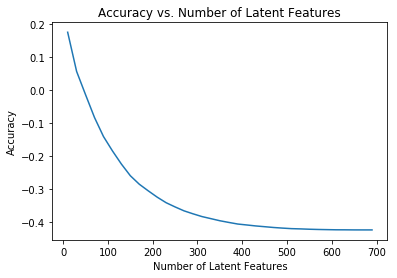

In [123]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.

In [125]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # user-item matrix of the training dataframe
    user_item_train = create_user_item_matrix(df_train)
    # user-item matrix of the testing dataframe
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_train.index)  # test user ids
    test_arts = list(user_item_train.columns)  # test article ids

    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [141]:
#How many users can we make predictions for in the test set?
print(user_item_test.shape[0]-len(np.setdiff1d(user_item_test.index, user_item_train.index)))
#How many users in the test set are we not able to make predictions for because of the cold start problem?
print(len(np.setdiff1d(user_item_test.index, user_item_train.index)))
#How many articles can we make predictions for in the test set?
print(user_item_test.shape[1])
#How many articles in the test set are we not able to make predictions for because of the cold start problem?
print(len(np.setdiff1d(user_item_test.columns, user_item_train.columns)))

20
662
574
0


In [142]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


Explore how well SVD works towards making predictions for recommendations on the test data.  

In [143]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [147]:
# Subset of rows in the user_item_test dataset
# Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

In [148]:
# Test data
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_2]

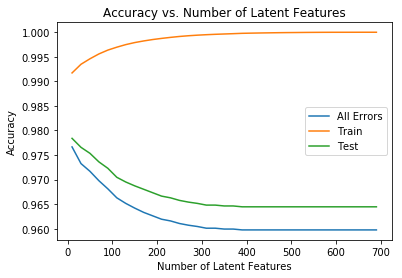

In [151]:
latent_feats = np.arange(10, 700+10, 20)

all_errs, train_errs, test_errs = [], [], []


for k in latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(sub_user_item_test)))/(sub_user_item_test.shape[0]*sub_user_item_test.shape[1])))

    # compute prediction accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))


plt.figure()
plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

Overall accuracy is very high. It is due to inbalance in class. We have many more 0's than 1's.
Increasing the number of laten features causes overfitting problem, where training accuracy increase to nearly 100% with the ammount of laten features included and test accuracy drops with the ammount of the laten features.

Solution to that problem could be cross validating and finding out how many laten features are needed to distinguish different subsets in the dataset provided.

In [152]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0